In [1]:
import glob
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpl_image
%matplotlib inline  
import cv2
import errno
import operator

!jupyter nbextension enable --py --sys-prefix widgetsnbextension
def log_progress(sequence, title='', every=1, size=None, end_msg='', removeAtTheEnd=False):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    if isinstance(sequence, dict):
                        val = ''
                    else:
                        val=sequence[index-1]
                            
                    label.value = u'{title} : {value} ({index} / {size})'.format(
                        title=title,
                        value=val,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = end_msg
        if removeAtTheEnd:
            box.close()
    

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
pathBasic='/home/jguerry/workspace/datasets/ONERA.ROOM'
allFolders=sorted(glob.glob(pathBasic+"/RGBD/*"))
pathFolder ='2017-04-26-14-06-49' #static, with light change

## Computing mean

In [3]:
folder='/home/jguerry/workspace/datasets/ONERA.ROOM/RGBD/'+pathFolder
print folder
print 'Globing...'
imgs_rgb=sorted(glob.glob(folder+"/image/*"))
imgs_depth=sorted(glob.glob(folder+"/depth_8bits/*"))
print 'Globbed'

means=np.zeros((len(imgs_rgb),1))
filenames=[]

print 'Evaluating mean for the whole RGB set...'
for i in log_progress(range(len(imgs_rgb)),title='Images', end_msg='Finished !'): 
    img=cv2.imread(imgs_rgb[i])
    mean=img.mean()
    
    
    fileName_rgb = os.path.split(os.path.split(imgs_rgb[i])[-1])[-1]
    newfileName_rgb = pathFolder+'_'+fileName_rgb[:-4]
    
    means[i]=mean
    filenames.append(newfileName_rgb)
print 'Finished.'

/home/jguerry/workspace/datasets/ONERA.ROOM/RGBD/2017-04-26-14-06-49
Globing...
Globbed
Evaluating mean for the whole RGB set...
Finished.


## Plotting evolution of mean luminosity

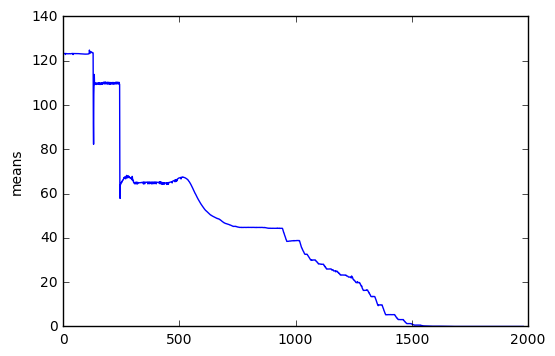

In [4]:
plt.plot(means)
plt.ylabel('means')
plt.show()

## Selecting images

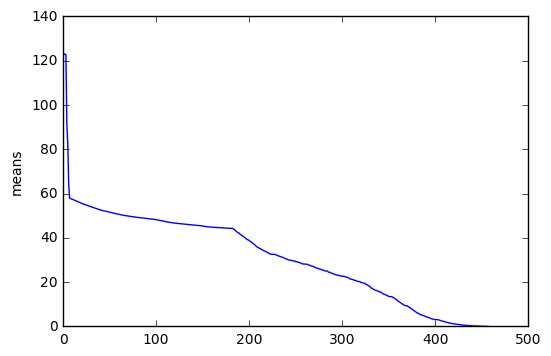

Selected points : 458


In [5]:
resolution = 10000.

mean_max = np.max(means)
mean_min = np.min(means)

delta=mean_max-mean_min
step=delta/resolution
steps = np.arange(mean_max,mean_min,-step)

selected_x=[]
last_x=0
last_intensity=1000
for intensity in log_progress(steps,title='Intensity steps', end_msg='Finished !'): 
    last_x=0
#     last_intensity=1000
    for x in range(last_x,len(means)):
        last_x=x
        if means[x]<intensity and intensity<last_intensity:
            selected_x.append(x)
            last_intensity=means[x]
            break
            
            
plt.plot(means[selected_x])
# plt.plot(selected_x)
plt.ylabel('means')
plt.show()

print 'Selected points :',len(selected_x)

#### Matplotlib style

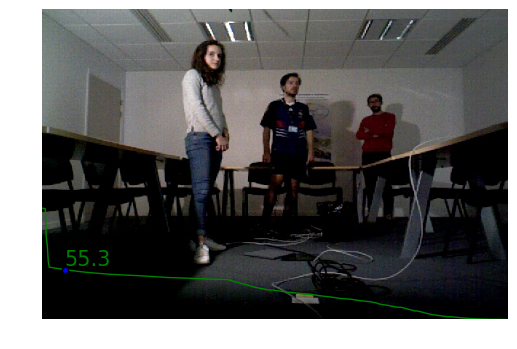

In [7]:
ratio=0.05
indice=int(ratio*len(selected_x))
path_img = imgs_rgb[selected_x[indice]]
mean_img = means[selected_x[indice],0]
im = mpl_image.imread(path_img)


nb_pts=len(selected_x)
width_of_im = 640/640*nb_pts
height_of_im = 480./640*nb_pts



fig, ax = plt.subplots()
ax.imshow(im, aspect='auto', extent=(0, width_of_im, 0,height_of_im ), zorder=-1)
plt.axis('off')
# ax.yaxis.tick_left()
# ax.tick_params(axis='y', colors='black', labelsize=15)
# ax.tick_params(axis='x', colors='black', labelsize=15)
# ax.grid(b=False, which='major', color='#D3D3D3', linestyle='-')

if ratio<0.5:
    verticalalignment='bottom'
    horizontalalignment='left'
else:
    verticalalignment='bottom'
    horizontalalignment='right'
ax.text(indice, mean_img,'{:.1f}'.format(mean_img), fontsize=15,color='green',verticalalignment=verticalalignment, horizontalalignment=horizontalalignment)
plt.plot(means[selected_x],alpha=1.0,color='green')
ax.scatter(indice,mean_img, alpha=1.0,zorder=+4)

ax = plt.gca();
ax.set_xlim(0.0, width_of_im);
ax.set_ylim(0, height_of_im);
# plt.savefig( '/tmp/match.png',bbox_inches='tight', transparent="True",pad_inches=0)


plt.show()

#### OpenCV style

In [8]:
def add_curve(im,ratio):
    
    color_aoe=(0,125,0) #ao english
    color_bg=(int(255*0.38),int(255*0.71),int(255*0.48)) #bud green 48%	71%	38% 
    color_bo=(int(255*0.0),int(255*0.33),int(255*0.80)) #Burnt Orange	#CC5500	80%	33%	0%
    color_cp=(int(255*0.80),int(255*0.73),int(255*0.94)) #Cameo Pink	#EFBBCC	94%	73%	80%
    
    offset_v = 2
    coeff_v = 2
    color_line=(0,255,255)
    color_point_bg=color_cp
    color_point=color_line #(20,20,250) #red


    nb_pts=len(selected_x)
    w = im.shape[1]
    h = im.shape[0]

    for i in range(len(selected_x)-1):

        x0 = int(640./len(selected_x)*i)
        y0 = int(h-coeff_v*means[selected_x[i],0]-offset_v)
        x1 = int(640./len(selected_x)*(i+1))
        y1 = int(h-coeff_v*means[selected_x[i+1],0]-offset_v)
        cv2.line(im,(x0,y0),(x1,y1),color_line,2)#,lineType=8)



    x_c = int(640./len(selected_x)*indice)
    y_c = int(h-coeff_v*means[selected_x[indice],0]-offset_v)
    text='{:.1f}'.format(mean_img)

    cv2.circle(im, (x_c,y_c), 7, color_point_bg,thickness=-1)    
    cv2.circle(im, (x_c,y_c), 5, color_point,thickness=-1)    
    if ratio<0.8:
        cv2.putText(im, text, (x_c+10,y_c-15), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=1, thickness=5, color=color_point_bg)
        cv2.putText(im, text, (x_c+10,y_c-15), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=1, thickness=2, color=color_point)
    else:

        cv2.putText(im, text, (x_c-50,y_c-15), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=1, thickness=5, color=color_point_bg)
        cv2.putText(im, text, (x_c-50,y_c-15), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=1, thickness=3, color=color_point)


    return im

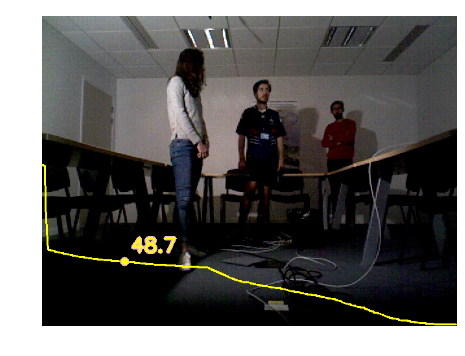

In [9]:
ratio=0.2

indice=int(ratio*len(selected_x))

path_img = imgs_rgb[selected_x[indice]]
mean_img = means[selected_x[indice],0]
im = cv2.imread(path_img)


# path_img = imgs_depth[selected_x[indice]]
# im_gray = cv2.imread(path_img)
# im = cv2.applyColorMap(im_gray, cv2.COLORMAP_OCEAN)


im = add_curve(im,ratio)
# im = rgbWithCurve(indice)
fig, ax = plt.subplots()
plt.axis('off')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

## Making the set

f = open('/home/jguerry/workspace/datasets/ONERA.ROOM/data_pv/sets/static_monotonous.txt', 'w')
for i in selected_x:      
    fileName_rgb = os.path.split(os.path.split(imgs_rgb[i])[-1])[-1]
    newfileName_rgb = pathFolder+'_'+fileName_rgb[:-4]
    f.write(newfileName_rgb+'\n')
print 'Finished.'
f.close()

48.2104752604


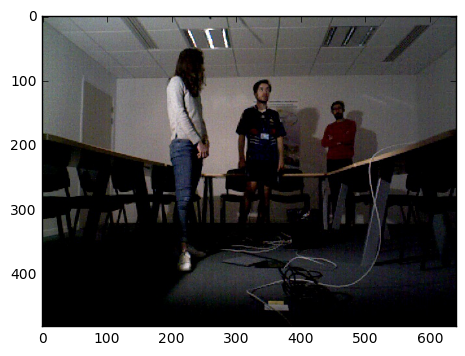

In [10]:
img=cv2.imread(imgs_rgb[selected_x[100]])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(img.mean())

## Load detections and show it

In [11]:
import glob
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpl_image
%matplotlib inline  
import cv2
import errno
import operator

import torch
import cPickle

from faster_rcnn import network
from faster_rcnn.faster_rcnn import FasterRCNN, RPN
from faster_rcnn.utils.timer import Timer
from faster_rcnn.fast_rcnn.nms_wrapper import nms

from faster_rcnn.fast_rcnn.bbox_transform import bbox_transform_inv, clip_boxes
from faster_rcnn.datasets.factory import get_imdb
from faster_rcnn.fast_rcnn.config import cfg, cfg_from_file, get_output_dir
from faster_rcnn.datasets.jg_voc_eval import voc_eval_ecmr as jg_voc_eval

In [26]:
# hyper-parameters
# ------------
# pytorchpath = '/data02/jguerry/jg_pyt/'
pytorchpath = '/home/jguerry/workspace/jg_dl/jg_pyt/'
cfg_file = pytorchpath+'experiments/cfgs/faster_rcnn_end2end_oneraroom.yml'
output_dir = pytorchpath+'output/faster_rcnn_oneraroom_exp/'
# load config
cfg_from_file(cfg_file)

use_07_metric = False

detections={}

# load data
imdb_name = 'oneraroom_static_monotonous_rgb'
imdb = get_imdb(imdb_name)
imdb.competition_mode(on=True)
cachedir = os.path.join(imdb._devkit_path, 'faster_rcnn', 'annotations_cache')
annopath = os.path.join(imdb._data_path,'annotations', '{:s}.xml')
imagesetfile = os.path.join(imdb._data_path,'sets',imdb._image_set + '.txt')

##### RGB detections
imdb_name = 'oneraroom_static_monotonous_rgb'
imdb_model = 'oneraroom_2017_no_static_rgb'
save_name = imdb_model+'_on_'+imdb_name
det_file = output_dir+imdb_name+'/detections_thresh_'+save_name+'.pkl'
with open(det_file, 'rb') as f:
    all_boxes = cPickle.load(f)
detections[save_name]=all_boxes

#####  D Detections
imdb_name = 'oneraroom_static_monotonous_depth_8bits'
imdb_model = 'oneraroom_2017_no_static_depth_8bits'
save_name = imdb_model+'_on_'+imdb_name
det_file = output_dir+imdb_name+'/detections_thresh_'+save_name+'.pkl'
with open(det_file, 'rb') as f:
    all_boxes = cPickle.load(f)
detections[save_name]=all_boxes

#####  X RGBD Detections
# imdb_name = 'oneraroom_static_monotonous_rgb'
save_name = 'oneraroom_x_thresh_2017_no_static_on_static_monotonous_rgbd_10000'
det_file = output_dir+save_name+'/detections_'+save_name+'.pkl'
with open(det_file, 'rb') as f:
    all_boxes = cPickle.load(f)
detections[save_name]=all_boxes

Remove empty annotations:  Done. [ 0 removed]


In [27]:
results={}

for key, all_boxes in detections.iteritems():

    for cls_ind, cls in enumerate(imdb.classes):
        if cls == '__background__':
            continue
        filename = imdb._get_voc_results_file_template().format(cls)
        with open(filename, 'wt') as f:
            for im_ind, index in enumerate(imdb.image_index):
                dets = all_boxes[cls_ind][im_ind]
                if len(dets) == 0:
                    continue
                # the VOCdevkit expects 1-based indices
                for k in xrange(dets.shape[0]):
                    f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                        format(index, dets[k, -1],              # filename(stem), score
                               dets[k, 0] + 1, dets[k, 1] + 1,  # x1, y1, x2, y2
                               dets[k, 2] + 1, dets[k, 3] + 1))


    for i, cls in enumerate(imdb._classes):
        if cls == '__background__':
            continue
        filename = imdb._get_voc_results_file_template().format(cls)
        rec, prec, ap, tp, fp, iou, npos, img_relative_tp, img_relative_fp,img_relative_d, new_all_boxes = jg_voc_eval(filename,
                                                                                    annopath,
                                                                                    imagesetfile,
                                                                                    cls, 
                                                                                    cachedir,
                                                                                    ovthresh=0.5,
                                                                                    use_07_metric = use_07_metric)
        results[key]={'rec':rec,'prec':prec,'ap':ap,'tp':tp,'fp':fp,'iou':iou,
                                     'npos':npos,'img_relative_tp':img_relative_tp,
                      'img_relative_fp':img_relative_fp,'img_relative_d':img_relative_d,
                     'new_all_boxes':new_all_boxes}


print 'Done.'

Done.


In [28]:
for key in results:
    results[key]['all_boxes_0']=[]
    results[key]['all_boxes_1']=[]
    img_boxes_sorted = sorted(results[key]['new_all_boxes'].items(), key=operator.itemgetter(0),reverse=False)
    for (img,boxes) in img_boxes_sorted:
        results[key]['all_boxes_0'].append([])
        results[key]['all_boxes_1'].append([])
        for box in boxes:
            det = list(box[1])+ [box[0]] #[bbox,conf]
            if box[2]==1:
                results[key]['all_boxes_1'][-1].append(det)
            elif box[2]==0:
                results[key]['all_boxes_0'][-1].append(det)
            else:
                print 'shit'
            
            


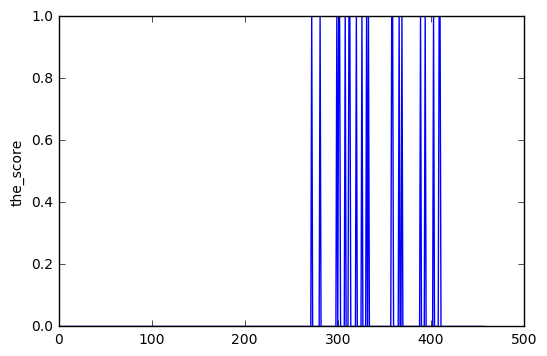

In [29]:
beta=-1.*0
alpha=3
gamma=alpha*3.
for key in results:
    results[key]['the_score']={}
    for img in results[key]['img_relative_tp']:
        results[key]['the_score'][img]=(alpha*results[key]['img_relative_tp'][img]+beta*results[key]['img_relative_fp'][img])/(gamma)#results[key]['img_relative_d'][img])
        
dict_img_relative_fp = results['oneraroom_2017_no_static_rgb_on_oneraroom_static_monotonous_rgb']['img_relative_fp']
dict_img_relative_fp_sorted = sorted(dict_img_relative_fp.items(), key=operator.itemgetter(0),reverse=False)
fp = []
for (key,value) in dict_img_relative_fp_sorted:
    fp.append(value)

plt.plot(fp)
plt.ylabel('the_score')
plt.show()        

## Visualisation

In [30]:
def add_detections(im, dets, color=(10,100,10), color_bg=(100,255,100) ,class_name='person', thresh=0.5):
    """Visual debugging of detections."""
    for i in range(np.minimum(10, dets.shape[0])):
        bbox = tuple(int(np.round(x)) for x in dets[i, :4])
        score = dets[i, -1]
        if score > thresh:
            cv2.rectangle(im, bbox[0:2], bbox[2:4], color, 4)
            #cv2.putText(im, '%s: %.3f' % (class_name, score), (bbox[0], bbox[1] + 15), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)
            cv2.putText(im, '%.3f' % (score), (bbox[0]+5, bbox[3] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, color_bg, thickness=5)
            cv2.putText(im, '%.3f' % (score), (bbox[0]+5, bbox[3] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, color, thickness=2)
            
    return im

def add_detections_false(im, dets, color=(10,10,200), color_bg=(100,100,255) ,class_name='person', thresh=0.5):
    """Visual debugging of detections."""
    for i in range(np.minimum(10, dets.shape[0])):
        bbox = tuple(int(np.round(x)) for x in dets[i, :4])
        score = dets[i, -1]
        if score > thresh:
            cv2.rectangle(im, bbox[0:2], bbox[2:4], color, 1)
            #cv2.putText(im, '%s: %.3f' % (class_name, score), (bbox[0], bbox[1] + 15), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)
            cv2.putText(im, '%.3f' % (score), (bbox[0]+5, bbox[3] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, color_bg, thickness=3)
            cv2.putText(im, '%.3f' % (score), (bbox[0]+5, bbox[3] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, color, thickness=1)
            
    return im

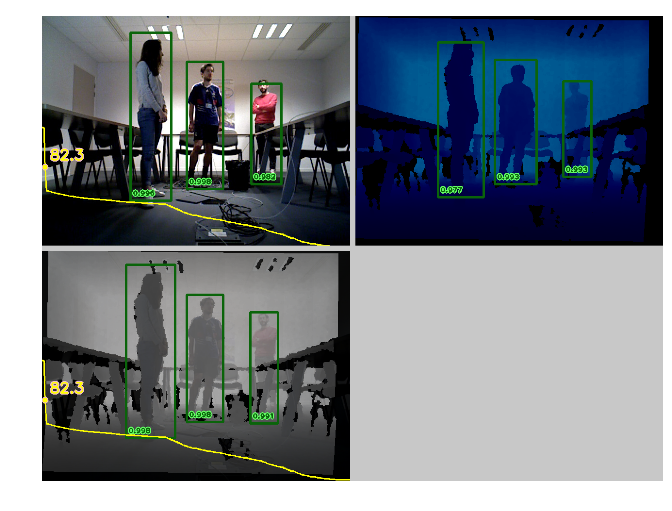

In [32]:
ratio=0

indice=5#int(ratio*len(selected_x))

# rgb
path_img = imgs_rgb[selected_x[indice]]
mean_img = means[selected_x[indice],0]
im_rgb = cv2.imread(path_img)
#depth
path_img = imgs_depth[selected_x[indice]]
im_gray = cv2.imread(path_img)
#composite
im_compo = np.zeros(im_rgb.shape, np.uint8)
im_compo = cv2.addWeighted(im_gray, 1, im_rgb, ratio+0.1, 0)

# im_norm = np.zeros(im_rgb.shape, np.uint8)
# cv2.normalize(im_rgb, im_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

######################################################################
key='oneraroom_2017_no_static_rgb_on_oneraroom_static_monotonous_rgb'
im_rgb = add_detections_false(im_rgb, np.array(results[key]['all_boxes_0'][indice]))
im_rgb = add_detections(im_rgb, np.array(results[key]['all_boxes_1'][indice]))
im_rgb = add_curve(im_rgb,ratio)



key='oneraroom_2017_no_static_depth_8bits_on_oneraroom_static_monotonous_depth_8bits'
im_depth = cv2.applyColorMap(im_gray, cv2.COLORMAP_OCEAN)
im_depth = add_detections_false(im_depth, np.array(results[key]['all_boxes_0'][indice]))
im_depth = add_detections(im_depth, np.array(results[key]['all_boxes_1'][indice]))
# im_depth = add_curve(im_depth,ratio)


# key='oneraroom_x_2017_no_static_on_static_monotonous_rgbd_10000'
key='oneraroom_x_thresh_2017_no_static_on_static_monotonous_rgbd_10000'
im_compo = add_detections_false(im_compo, np.array(results[key]['all_boxes_0'][indice]))
im_compo = add_detections(im_compo, np.array(results[key]['all_boxes_1'][indice]))
im_compo = add_curve(im_compo,ratio)
######################################################################

im_full= 200*np.ones((2*im_rgb.shape[0],2*im_rgb.shape[1],3), np.uint8)
im_full[0:im_rgb.shape[0],0:im_rgb.shape[1],:]=im_rgb
im_full[:im_rgb.shape[0],im_rgb.shape[1]:,:]=im_depth
im_full[im_rgb.shape[0]:,:im_rgb.shape[1],:]=im_compo

cv2.line(im_full,(im_rgb.shape[1],0),(im_rgb.shape[1],im_full.shape[0]),(200,200,200),10)
cv2.line(im_full,(0,im_rgb.shape[0]),(im_full.shape[1],im_rgb.shape[0]),(200,200,200),10)

size=2
fig, ax = plt.subplots(figsize=(size*4, size*3))
plt.axis('off')
plt.imshow(cv2.cvtColor(im_full, cv2.COLOR_BGR2RGB),aspect='auto')

## Make video

4 screens : RGB, D, Composite (gray, depth, ???), explanations (legend, analyse)
Il faut donc 4 fonctions qui retourne chaque composante pour construire l'image finale à mettre dans la vidéo

In [33]:
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter("/home/jguerry/Downloads/output.avi", fourcc, 20, (2*640,2*480),True)
out.isOpened()

True

In [35]:
for indice in log_progress(range(len(selected_x)),title='Frames', end_msg='Finished !'): 
    # rgb
    path_img = imgs_rgb[selected_x[indice]]
    mean_img = means[selected_x[indice],0]
    im_rgb = cv2.imread(path_img)
    #depth
    path_img = imgs_depth[selected_x[indice]]
    im_gray = cv2.imread(path_img)
    #composite
    im_compo = np.zeros(im_rgb.shape, np.uint8)
    im_compo = cv2.addWeighted(im_gray, 1, im_rgb, ratio+0.1, 0)

    # im_norm = np.zeros(im_rgb.shape, np.uint8)
    # cv2.normalize(im_rgb, im_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    
    ratio=1.*indice/len(selected_x)
    ######################################################################
    key='oneraroom_2017_no_static_rgb_on_oneraroom_static_monotonous_rgb'
    im_rgb = add_detections_false(im_rgb, np.array(results[key]['all_boxes_0'][indice]))
    im_rgb = add_detections(im_rgb, np.array(results[key]['all_boxes_1'][indice]))
    im_rgb = add_curve(im_rgb,ratio)



    key='oneraroom_2017_no_static_depth_8bits_on_oneraroom_static_monotonous_depth_8bits'
    im_depth = cv2.applyColorMap(im_gray, cv2.COLORMAP_OCEAN)
    im_depth = add_detections_false(im_depth, np.array(results[key]['all_boxes_0'][indice]))
    im_depth = add_detections(im_depth, np.array(results[key]['all_boxes_1'][indice]))
    # im_depth = add_curve(im_depth,ratio)



    # key='oneraroom_x_2017_no_static_on_static_monotonous_rgbd_10000'
    key='oneraroom_x_thresh_2017_no_static_on_static_monotonous_rgbd_10000'
    im_compo = add_detections_false(im_compo, np.array(results[key]['all_boxes_0'][indice]))
    im_compo = add_detections(im_compo, np.array(results[key]['all_boxes_1'][indice]))
    im_compo = add_curve(im_compo,ratio)
    ######################################################################

    im_full= 200*np.ones((2*im_rgb.shape[0],2*im_rgb.shape[1],3), np.uint8)
    im_full[0:im_rgb.shape[0],0:im_rgb.shape[1],:]=im_rgb
    im_full[:im_rgb.shape[0],im_rgb.shape[1]:,:]=im_depth
    im_full[im_rgb.shape[0]:,:im_rgb.shape[1],:]=im_compo

    cv2.line(im_full,(im_rgb.shape[1],0),(im_rgb.shape[1],im_full.shape[0]),(200,200,200),10)
    cv2.line(im_full,(0,im_rgb.shape[0]),(im_full.shape[1],im_rgb.shape[0]),(200,200,200),10)
    
    #     if indice<10:
    #         for i in range(3):
    #             out.write(im_full)
    #     elif indice>350:
    #         for i in range(2):
    #             out.write(im_full)
    #     elif indice>410:
    #         for i in range(3):
    #             out.write(im_full)
    #     else:
    #         out.write(im_full)
    out.write(im_full)
out.release()